# CS 168- Homework 1

In order to submit this homework, do the following steps:

(1) Make a local copy by clicking on : 
File >> Save Copy in Drive

(2) Once you have finished the homework, you need to provide the link to your completed Colab Notebook. In order to obtain a shareable link:


*   Click on Share on the right upper corner. 
*   In the new window click on Get Shareable link for obtaining the link. Make sure you set the privacy such that " **Anyone with the link** " can access it.


3) Put the link you obtained in a text file and make a submission to CCLE under Homework 1.



### (0 Points)  Load and rotate an image


The shape of the phantom image is: (400, 400) 


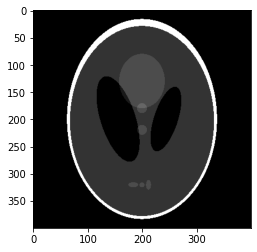

In [1]:
import scipy
from scipy import misc
import numpy as np
from matplotlib import pyplot as plt
from skimage.data import shepp_logan_phantom

img = shepp_logan_phantom()

plt.figure()
plt.imshow(img, cmap='gray')

print('The shape of the phantom image is: {} '.format(np.shape(img)))

 Rotate the image for 90 degrees.





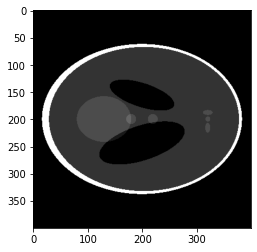

In [2]:
from skimage.transform import rotate
rotated_image=rotate(img,90)

plt.figure()
plt.imshow(rotated_image, cmap='gray')
plt.show()

### Radon Transform and sinogram

In tomography, given a set of 1-D projections and the angles at which the projections were taken, the goal is to reconstruct a 2-D image.

The 1-D projections are obtained by using a Radon transform. The Radon transform $g(t,\theta)$ at angle $\theta$ and dinstance t is defined as

$$g(t, \theta) = \int_{-\infty}^{+\infty}\int_{-\infty}^{+\infty}f(x, y)\delta(xcos\theta + ysin\theta -t)dxdy$$



### ( 10 Points) Radon Transform using Scikit-image Package 

---



Using the scikit-image package, apply the radon transform and **obtain a sinogram** of the image (Look at the documentation for radon transform function [here](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.radon)).

**Visualize** the results. 


**Hint**: Use the np.linspace function ( from numpy) to create an array of angles ( from 0 to 180). The length of the array should be the same as the width of the image( or height since the height and width are the same for this image). Pass the array of angle to the radon function as defined in scikit-image. 

Your results shouuld look like the image provided below. 




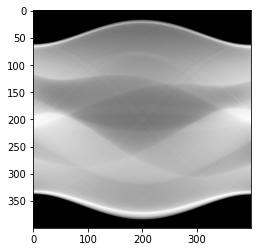

In [3]:
from skimage.transform import radon
from skimage.transform import rotate

num_projections=len(img)
theta = np.linspace(0, 180, num_projections, endpoint=False)
sinogram = radon(img, theta=theta, circle=True)

plt.figure()
plt.imshow(sinogram, cmap='Greys_r')
plt.show()


### ( 20 Points) Radon Transform **without** using Scikit-image Package 
---

**Implement** the radon transform function yourself and obtain a sinogram of the image.

**Visualize** the results. 

**Hint**: Here, we intend to calculate the Radon transform line integration numerically. The basic idea is to rotate the image using the rotation function ( from Scikit-image ) and between 0 to 180 degrees and summing up the intensity values by using the sum function ( from python).

Your results shouuld look like the image provided below. 


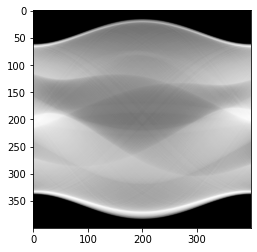

In [4]:
def radon_transform(image, theta):
  r_array = np.zeros((len(theta), len(image)))
  for i in range(len(theta)):
    rotated = rotate(image, -1*theta[i])
    r_array[:,i] = sum(rotated)
  return r_array

image = shepp_logan_phantom()
num_projections = len(image)
theta = np.linspace(0, 180, num_projections, endpoint=False)
sinogram = radon_transform(img, theta)

plt.figure()
plt.imshow(sinogram, cmap='Greys_r')
plt.show()


### Backprojection (Inverse Radon Transform) **without** using Scikit-image Package 

### ( 30 Points) Calculate the Filtered Fourier transform of the sinogram which you obtained in the previous section ( your implementation) by Using Numpy Discrete Fast Fourier transform (np.fft.fft) function.

From a high-level perspective, we would like to transform to the frequency space ( by taking the Fourier transform), suppress the low frequencies and eventually take the inverse Fourier transform to transform back.


Hint1: First create an array of angles between $-\pi$ to $\pi$. Then take the absloute value of the array elements and use the numpy.fft.fftshift function ( numpu library) to Shift the zero-frequency component to the center of the spectrum. Let's assume that the name of the resultant array is the *filtered response*.

Hint2: You then need to loop through all the angles in the sinogram, take the Fourier transform of the sinogram using numpy.fft.fft, take the element-wise multiplication between the result of the fourier transform and previously calculated *filtered response* and eventually calculate the inverse Fourier transform by using the numpy.fft.ifft function. 

Hint3: Eventually, only allow the real components of the result of inverse Fourier transform by using the numpy.real function. 


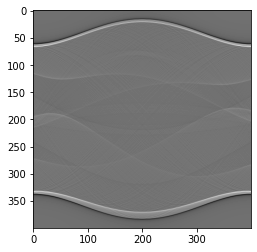

In [5]:
import pdb
import numpy as np

m, n = sinogram.shape
w = np.linspace(-np.pi,np.pi,n) 
filtered_response = np.fft.fftshift(abs(w))

fft_sinogram = np.fft.fft2(sinogram)
for i in range(len(fft_sinogram)):
  fft_sinogram[i] = (fft_sinogram[i])*(filtered_response[i])

filtered_sinogram = np.fft.ifft2(fft_sinogram).real

plt.imshow(filtered_sinogram, cmap='gray')
plt.show()


### ( 40 Points) Using the filtered responses (projections) and given the angles in which the projections were taken, reconstruct the input image.

Hint1: First find the middle index of projections. Let's call this middle index as *m*.

Also, create a 2D grid by using the numpy.mgrid function ( it should give you X and Y coordinates).  Make appropriate changes to the X and Y coordinates such that the origin is in the middle of the grid. 

Hint 2: Then loop through  all the angles between 0 to 180 and figure out which projection to add to which spot. In order to do this, you may want to calculate $m+xcos\theta - ysin\theta$ and find the spots ( points) which are between 0 to size of the image plane. Once the coordinate of these spots are found, simply find the corresponding filtered responses ( projections) and add them to a final matrix for the reconstruction of the image.

**Visualize** the result.

Your results shouuld look like the sample image provided. 




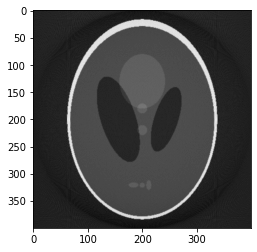

In [6]:
# Taken from TA 

mid_index = (m)//2
reconstructed = np.zeros((m,n))
[Y,X] = np.mgrid[0:m, 0:n]
x_pr = X - mid_index
y_pr = Y - mid_index

theta = np.linspace(0, 180, n, endpoint=False)
th = (np.pi/180)*theta

for i in range(len(th)):
  cur_points = mid_index + x_pr * np.cos(th[i]) - y_pr * np.sin(th[i])
  spot = np.where((cur_points > 0)&(cur_points < n))
  cur_reconstructed = np.zeros((m,n))
  new_points = cur_points[spot].astype('int64')
  cur_reconstructed[spot]=filtered_sinogram[new_points, i]
  reconstructed = reconstructed + cur_reconstructed

reconstructed = reconstructed*(np.pi)/(2*len(th))
plt.imshow(reconstructed, cmap='gray')
plt.show()